<a href="https://colab.research.google.com/github/JScottLopez/JScottLopez/blob/main/Lopez_J_DDS_8555v1_Week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Author: Joseph Lopez
#3/28/2025

#Install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

#Load data from a CSV file
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

Mounted at /content/drive


In [ ]:
#Align train and test data columns
train_cols = set(train.columns)
test_cols = set(test.columns)
common_cols = list(train_cols.intersection(test_cols))
if 'NObeyesdad' in train_cols and 'NObeyesdad' not in common_cols:
  train = train[common_cols + ['NObeyesdad']]
else:
  train = train[common_cols + ['NObeyesdad']]

test = test[common_cols]

#Use one hot encoding to sub numerical values for categorical values
train = pd.get_dummies(train, columns=['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS'], dtype=int)
test = pd.get_dummies(test, columns=['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS'], dtype=int)

In [ ]:
#Ensure output meets submission requirements
target_size = 13840
if len(train) > target_size:
  train = train.sample(n=target_size, random_state=42)

#Subset columns
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Confusion Matrix: 
[[283  32   1   1   0   4   2]
 [ 28 335   0   0   0  39   9]
 [  0   3 324  12   0  12  23]
 [  0   0  20 407   1   0   4]
 [  0   0   4   0 523   0   0]
 [  4  57  13   0   0 225  50]
 [  1   9  31   6   0  45 260]]

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.88      0.89       323
      Normal_Weight       0.77      0.82      0.79       411
     Obesity_Type_I       0.82      0.87      0.84       374
    Obesity_Type_II       0.96      0.94      0.95       432
   Obesity_Type_III       1.00      0.99      1.00       527
 Overweight_Level_I       0.69      0.64      0.67       349
Overweight_Level_II       0.75      0.74      0.74       352

           accuracy                           0.85      2768
          macro avg       0.84      0.84      0.84      2768
       weighted avg       0.85      0.85      0.85      2768



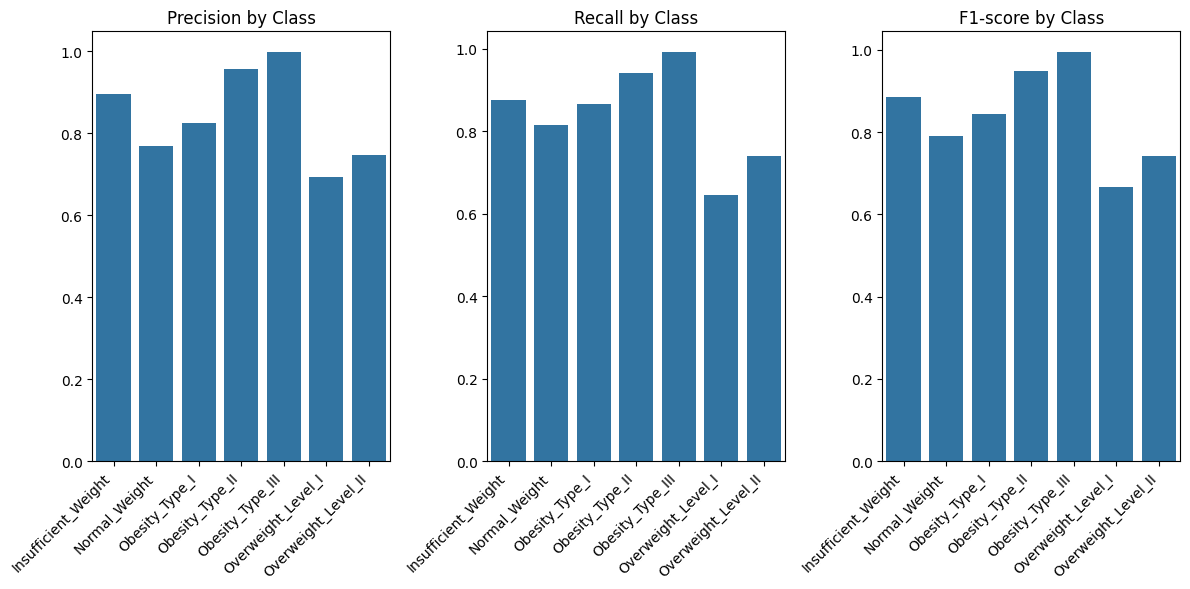

In [ ]:
#Decision Tree Model
#Initialize and fit model
DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(X_train_scaled, y_train)
#Make predictions
y_pred = DT_model.predict(X_test_scaled)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ')
print(cm)
print('\nClassification Report:')
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert to CSV
test_data_for_prediction = test.drop('id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
  test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
submission5 = pd.DataFrame({'id': test['id'], 'NObeyesdad': DT_model.predict(scaler.transform(test_data_for_prediction))})

Confusion Matrix: 
[[292  27   0   1   0   1   2]
 [ 21 359   0   0   0  25   6]
 [  0   1 324  13   0  12  24]
 [  0   0  18 411   0   0   3]
 [  0   0   2   0 525   0   0]
 [  6  36   7   0   0 249  51]
 [  1   6  21   2   0  39 283]]

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.90      0.91       323
      Normal_Weight       0.84      0.87      0.85       411
     Obesity_Type_I       0.87      0.87      0.87       374
    Obesity_Type_II       0.96      0.95      0.96       432
   Obesity_Type_III       1.00      1.00      1.00       527
 Overweight_Level_I       0.76      0.71      0.74       349
Overweight_Level_II       0.77      0.80      0.79       352

           accuracy                           0.88      2768
          macro avg       0.87      0.87      0.87      2768
       weighted avg       0.88      0.88      0.88      2768



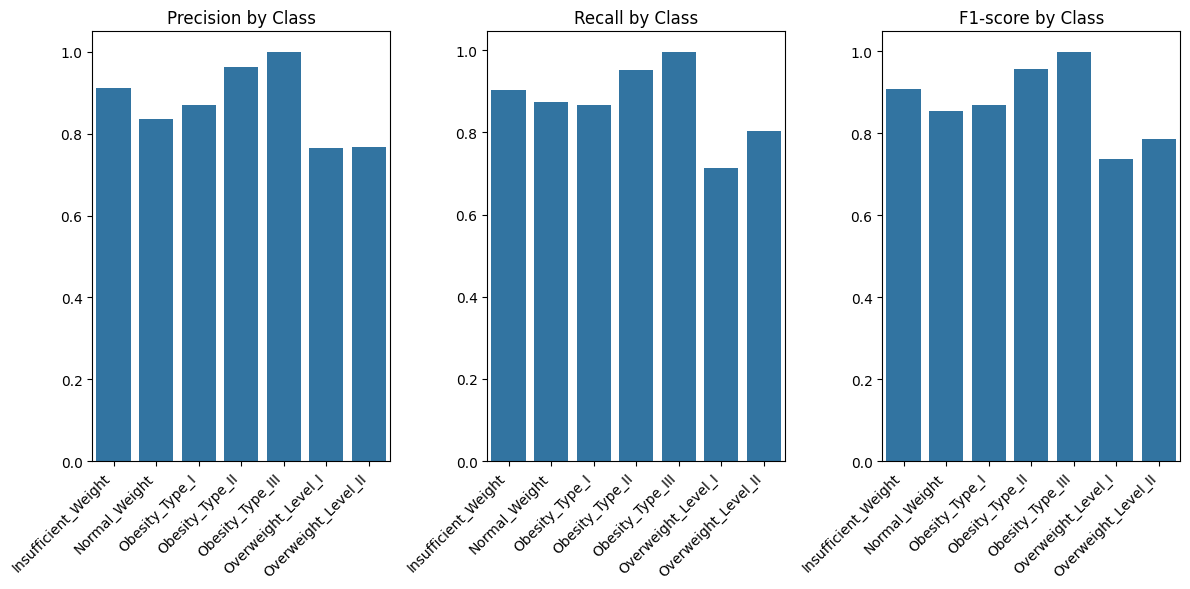

In [ ]:
#Bagged Classifier
#Initialize and fit model
BC_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
BC_model.fit(X_train_scaled, y_train)
#Make predictions
y_pred = BC_model.predict(X_test_scaled)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ')
print(cm)
print('\nClassification Report:')
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert to CSV
test_data_for_prediction = test.drop('id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
          test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
submission7 = pd.DataFrame({'id': test['id'], 'NObeyesdad': BC_model.predict(scaler.transform(test_data_for_prediction))})

Confusion Matrix:
[[295  23   0   1   0   4   0]
 [ 18 363   0   0   0  23   7]
 [  1   2 314  15   0  13  29]
 [  0   0   8 422   0   0   2]
 [  0   0   0   0 526   1   0]
 [  5  52   8   0   0 224  60]
 [  0  13  16   2   0  28 293]]

Classfication Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.91      0.92       323
      Normal_Weight       0.80      0.88      0.84       411
     Obesity_Type_I       0.91      0.84      0.87       374
    Obesity_Type_II       0.96      0.98      0.97       432
   Obesity_Type_III       1.00      1.00      1.00       527
 Overweight_Level_I       0.76      0.64      0.70       349
Overweight_Level_II       0.75      0.83      0.79       352

           accuracy                           0.88      2768
          macro avg       0.87      0.87      0.87      2768
       weighted avg       0.88      0.88      0.88      2768



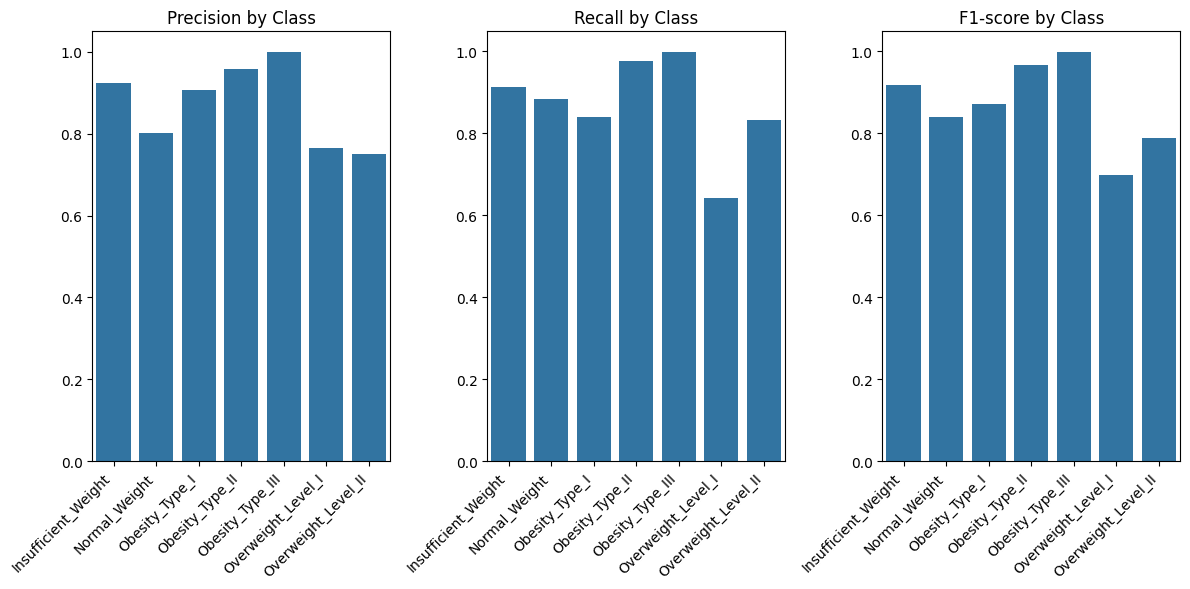

In [ ]:
#Random Forest Classifier
#Initialize and fit model
RFC_model = RandomForestClassifier(random_state=42)
RFC_model.fit(X_train_scaled, y_train)
#Make predictions
y_pred = RFC_model.predict(X_test_scaled)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('\nClassfication Report:')
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert output to CSV file
test_data_for_prediction = test.drop('id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
    test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
submission6 = pd.DataFrame({'id': test['id'], 'NObeyesdad': RFC_model.predict(scaler.transform(test_data_for_prediction))})

Confusion Matrix
[[297  22   0   1   0   3   0]
 [ 15 364   1   0   0  26   5]
 [  1   1 330  11   0  10  21]
 [  0   0  10 420   0   0   2]
 [  0   0   1   0 526   0   0]
 [  6  36   9   0   0 266  32]
 [  1   8  18   6   0  23 296]]

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.92      0.92       323
      Normal_Weight       0.84      0.89      0.86       411
     Obesity_Type_I       0.89      0.88      0.89       374
    Obesity_Type_II       0.96      0.97      0.97       432
   Obesity_Type_III       1.00      1.00      1.00       527
 Overweight_Level_I       0.81      0.76      0.79       349
Overweight_Level_II       0.83      0.84      0.84       352

           accuracy                           0.90      2768
          macro avg       0.90      0.89      0.89      2768
       weighted avg       0.90      0.90      0.90      2768



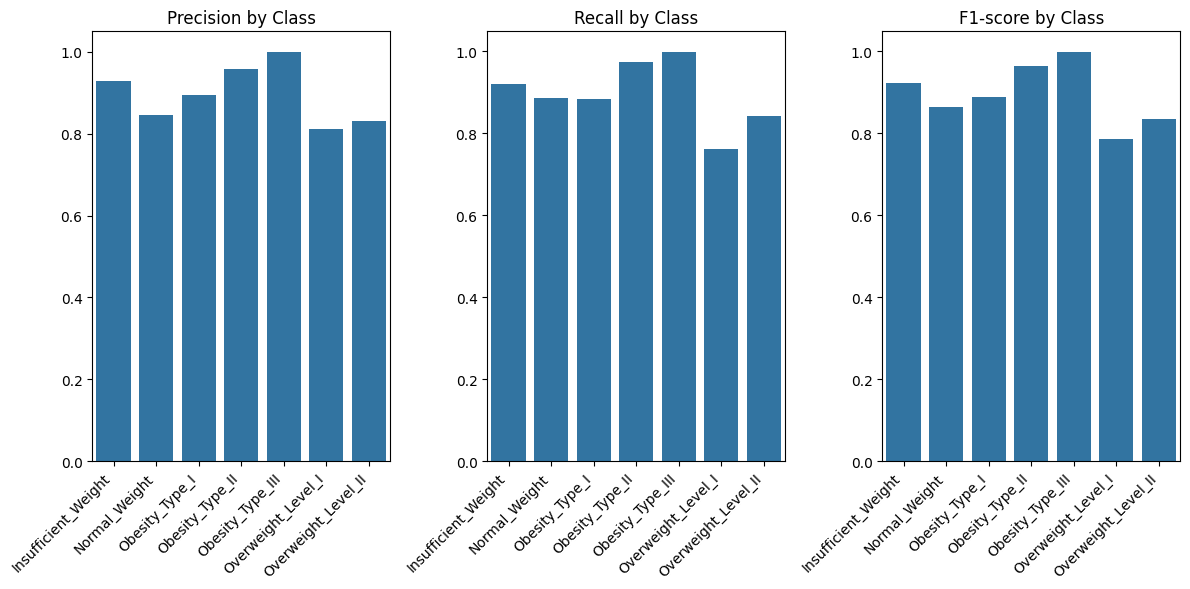

In [ ]:
#Gradient Boosted Model
#Initialize and fit model
GB_model = GradientBoostingClassifier(random_state = 42)
GB_model.fit(X_train_scaled, y_train)
#Make predictions
y_pred = GB_model.predict(X_test_scaled)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print('\nClassification Report:')
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert to CSV
test_data_for_prediction = test.drop('id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
  test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
submission8 = pd.DataFrame({'id': test['id'], 'NObeyesdad': GB_model.predict(scaler.transform(test_data_for_prediction))})

In [ ]:
#Convert to CSV files
submission5.to_csv('submission5.csv', index=False)
submission6.to_csv('submission6.csv', index=False)
submission7.to_csv('submission7.csv', index=False)
submission8.to_csv('submission8.csv', index=False)